[[ 2.14155926e-09 -8.62909175e-06  1.38482621e-02]
 [ 8.73413219e-06  1.65720096e-07 -1.73358553e-01]
 [-1.39843194e-02  1.71541415e-01  1.00000000e+00]]


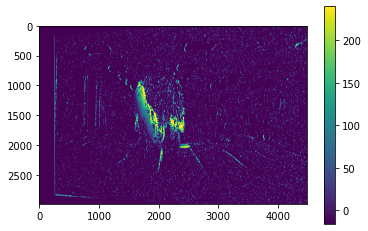

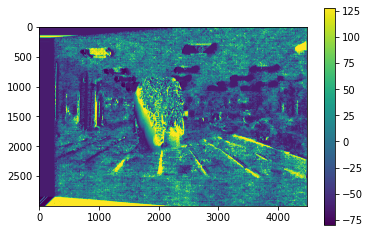

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img1 = cv.imread(r'C:\Users\jitbh\OneDrive\Desktop\DSC_0714.jpg',cv.IMREAD_GRAYSCALE)  #queryimage # left image
img2 = cv.imread(r'C:\Users\jitbh\OneDrive\Desktop\DSC_0715.jpg',cv.IMREAD_GRAYSCALE) #trainimage # right image
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1=[]
pts2=[]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.45*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
print(F)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

h1, w1 = img1.shape
h2, w2 = img2.shape
thresh = 0
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1), threshold=thresh,
)

############## Undistort (Rectify) ##############
imgL_undistorted = cv.warpPerspective(img1, H1, (w1, h1))
imgR_undistorted = cv.warpPerspective(img2, H2, (w2, h2))

# Using StereoBM
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_BM)
plt.colorbar()
plt.show()
# Using StereoSGBM
# Set disparity parameters. Note: disparity range is tuned according to
#  specific parameters obtained through trial and error.
win_size = 2
min_disp = -4
max_disp = 9
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=5,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * win_size ** 2,
    P2=32 * 3 * win_size ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_SGBM)
plt.colorbar()
plt.show()